# Univariate LSTM Time Series Model for Adj Close Price Forecasting 

#### Target Company
* TESLA (Symbol: TSLA)

#### Time Periods of Historical Data
* 4 Years (~ 2022/Jan/19)

#### Target Feature
* Adj Close

In [1]:
import warnings
warnings.filterwarnings(action='ignore')
import matplotlib.pyplot as plt

%matplotlib inline
import pandas as pd
import numpy as np
from datetime import datetime
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
import pandas_datareader as pdr
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers.schedules import PolynomialDecay
from tensorflow.keras.optimizers import Adam
from IPython.display import clear_output
import math
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

### Data Parsing & Plotting

In [2]:
def plot_ticker(df):

    fig = plt.figure(figsize=(10, 5))
    plt.plot(df, color = 'purple', label = 'Adj Close')

    plt.xticks(rotation=45, color='teal', size=12)
    plt.yticks(rotation=45, color='teal', size=12)

    plt.xlabel('Dates', {'color': 'orange', 'fontsize':12})
    plt.ylabel('Adj Close', {'color': 'orange', 'fontsize':12})

    plt.title(str(symbol.upper())+' '+'Adj Close Price', color='purple', size=20)

    # Plotting the horizontal line for min & max values along with the adj close prices
    max_price = np.round(np.max(df['Adj Close']),3)
    min_price = np.round(np.min(df['Adj Close']),3)
    plt.axhline(max_price, color='r', linestyle='dashed')
    plt.axhline(min_price, color='b', linestyle='dashed')
    
    # coordinate for the text position (x-axis)
    coord = datetime.strptime(end_date,'%Y%m%d')
    coord = coord - relativedelta(months=3)
    # y-axis = max and min prices + 3
    plt.text(coord, max_price+5, 'Max = $'+str(max_price), size=12, color='r')
    plt.text(coord, min_price+5, 'Min = $'+str(min_price), size=12, color='b')
    
    plt.legend()
    plt.grid(True)

    plt.show()

In [3]:
def adj_close_price(): 
    global symbol, end_date, start_date

    end_date = input("Set a date (yyyymmdd):")
    time_gap = input("years gap:")
    start_date = str(int(end_date) - (int(time_gap) * 10000))
    
    symbol = input("Symbol:")
    adjClose_df = pdr.get_data_yahoo(symbol, start_date, end_date) 
    adjClose_df = adjClose_df[["Adj Close"]]
    
    plot_ticker(adjClose_df)
    
    return adjClose_df

Set a date (yyyymmdd):20220120
years gap:4
Symbol:tsla


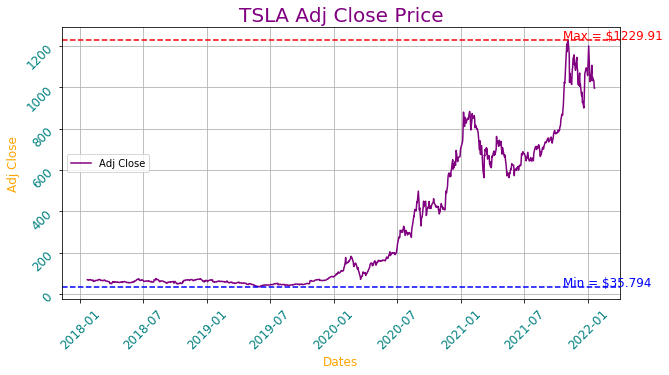

In [7]:
adjClose_df = adj_close_price()

In [8]:
adjClose_df

,Adj Close
Date,
2018-01-22,70.311996
2018-01-23,70.557999
2018-01-24,69.178001
2018-01-25,67.528000
2018-01-26,68.570000
...,...
2022-01-13,1031.560059
2022-01-14,1049.609985
2022-01-18,1030.510010


### Preprocessing Data Set

In [9]:
# Scaling the adj close price values 
scaler = MinMaxScaler(feature_range=(0,1))
scaled_df = scaler.fit_transform(np.array(adjClose_df['Adj Close']).reshape(-1,1))

In [10]:
# train test split
train_size = int(len(scaled_df)*0.8)
test_size = len(scaled_df)-train_size
train_df, test_df = scaled_df[0:train_size], scaled_df[train_size:] 
print(len(scaled_df),"=",train_size," + ",test_size)

1008 = 806  +  202


In [11]:
# assign X and Y based on time steps
def assign(data, timestep = None):
    X, y = [],[]
    
    if timestep == None:
        default_timestep = 10
        for i in range(len(data)-default_timestep-1):
            values_X = data[i:(i+default_timestep)]
            values_y = data[i+default_timestep,0]
            
            X.append(values_X)
            y.append(values_y)
        
    else:
        for i in range(len(data)-timestep-1):  
            values_X = data[i:(i+timestep)]
            values_y = data[i+timestep,0]
            
            X.append(values_X)
            y.append(values_y)
    
    return np.array(X), np.array(y)

In [12]:
timestep=100

X_train, y_train = assign(train_df, timestep)
X_test, y_test = assign(test_df, timestep)

In [13]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(705, 100, 1) (705,)
(101, 100, 1) (101,)


### Building Stacked LSTM Model

In [15]:
# LSTM Params
# Activation: tanh
# Recurrent Activation: sigmoid
# Learning Rate: default(0.01)
# Dropout: 0
# Output D: 50

# Output Dense Params
# Activation: Linear
# Output D: 1
config = {'loss':'mean_squared_error',
          'optimizer':'adam', 
          'epoch':100,
          'batch_size':32, 
          'metric':'mse',
          'verbose':1}

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1],1)))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))

model.compile(loss = config['loss'], 
              optimizer = config['optimizer'],
              metrics=[config['metric']])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 100, 50)           10400     
                                                                 
 lstm_4 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_5 (LSTM)               (None, 50)                20200     
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [16]:
# Customized Callback
class PlotLearning(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.metric = []
        self.val_metric = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.metric.append(logs.get(config['metric']))
        self.val_metric.append(logs.get('val_'+config["metric"]))
        self.i += 1
        
        fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True)
        fig.set_size_inches(10.5, 7.5)
        fig.suptitle('Processing',size = 20)
        clear_output(wait=True)
        ax1.set_yscale('log')
        ax1.plot(self.x, self.losses, label="Train Loss")
        ax1.plot(self.x, self.val_losses, label="Valid Loss")
        ax1.legend()
        
        
        ax2.plot(self.x, self.metric, label="Train_"+config['metric'])
        ax2.plot(self.x, self.val_metric, label="Valid_"+config['metric'])
        ax2.legend()
        
        plt.show();
        
plot = PlotLearning()

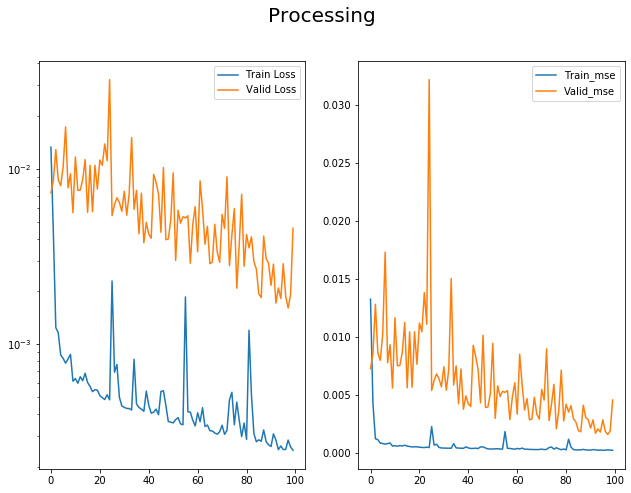

23/23 [==============================] - 2s 84ms/step - loss: 2.4872e-04 - mse: 2.4872e-04 - val_loss: 0.0046 - val_mse: 0.0046


In [17]:
history = model.fit(X_train, y_train,
                    validation_data = (X_test, y_test), 
                    epochs=config["epoch"], 
                    batch_size=config["batch_size"],
                    verbose=config['verbose'],
                    callbacks=[plot])

### Evaluation 
* Root Mean Squared Error
* Mean Absolute Percentage Error

In [18]:
# Predict train & test sets

train_pred = model.predict(X_train)
train_pred_inverse = scaler.inverse_transform(train_pred)
y_train_inverse = scaler.inverse_transform(np.array(y_train.reshape(-1,1)))

test_pred = model.predict(X_test)
test_pred_inverse = scaler.inverse_transform(test_pred)
y_test_inverse = scaler.inverse_transform(np.array(y_test.reshape(-1,1)))

In [19]:
# Root Mean Squared Error for train & test sets

rmse_train = math.sqrt(mean_squared_error(y_train_inverse, train_pred_inverse))
rmse_test = math.sqrt(mean_squared_error(y_test_inverse, test_pred_inverse))
print('RMSE for train: %0.2f' % rmse_train)
print('RMSE for test: %0.2f' % rmse_test)

RMSE for train: 20.27
RMSE for test: 80.83


In [20]:
# Mean Absolute Percentage Error

mape_train = math.sqrt(mean_absolute_percentage_error(y_train_inverse, train_pred_inverse))
mape_test = math.sqrt(mean_absolute_percentage_error(y_test_inverse, test_pred_inverse))
print('MAPE for train: %0.2f' % mape_train)
print('MAPE for test: %0.2f' % mape_test)

MAPE for train: 0.27
MAPE for test: 0.26


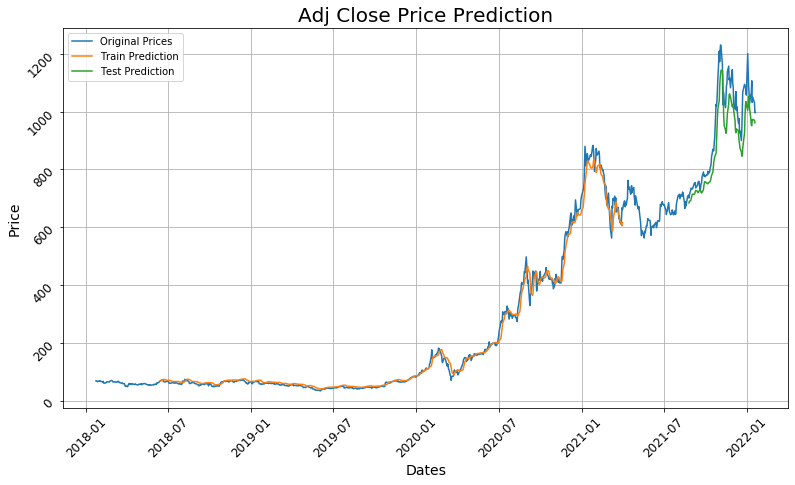

In [22]:
# create an array for train prediction values
timesteps = 100
train_prediction_array = np.empty_like(scaled_df)
train_prediction_array[:,] = np.nan
train_prediction_array[timesteps : len(y_train)+timesteps, ] = train_pred_inverse

# create an array for test prediction values
test_prediction_array = np.empty_like(scaled_df)
test_prediction_array[:,] = np.nan
test_prediction_array[len(y_train)+(timesteps*2)+1 : len(scaled_df)-1, ] = test_pred_inverse

# plot baseline and predictions
plt.figure(figsize=(13,7))

plt.xticks(rotation=45, size=12)
plt.yticks(rotation=45, size=12)

plt.xlabel('Dates', size = 14)
plt.ylabel('Price', size = 14)
plt.title('Adj Close Price Prediction', size=20)

plt.plot(adjClose_df.index, scaler.inverse_transform(scaled_df), label = "Original Prices")
plt.plot(adjClose_df.index, train_prediction_array, label = "Train Prediction")
plt.plot(adjClose_df.index, test_prediction_array, label = "Test Prediction")

plt.grid(True)
plt.legend()
plt.show()

### Model2 - Replace the last LSTM layer to Dense layer with ReLu Activation Function
* bach: 32 -> 16
* optimizer: adam
* learning rate: default -> scheduler 
* drop-out: 0.2

In [23]:
# Prepare data
train_df2 = train_df.copy()
test_df2 = test_df.copy()
X_train2 = X_train.copy() 
y_train2 = y_train.copy()
X_test2 = X_test.copy()
y_test2 = y_test.copy()

In [24]:
batch_size = 16
num_epochs = 100
# The number of training steps is the number of samples in the dataset, divided by the batch size then multiplied
# by the total number of epochs
num_train_steps = len(train_df2)/batch_size*num_epochs
lr_scheduler = PolynomialDecay(
    initial_learning_rate=5e-5, end_learning_rate=0.0, decay_steps=num_train_steps
)

In [25]:
# LSTM Params
# Activation: tanh
# Recurrent Activation: sigmoid
# Dropout: 0
# Output D: 50

# Output Dense Params
# Activation: Linear
# Output D: 1
config = {'loss':'mean_squared_error',
          'optimizer':Adam(learning_rate=lr_scheduler), 
          'epoch':100,
          'batch_size':16,
          'dropout': 0.2,
          'metric':'mse',
          'verbose':1}

model2 = Sequential()
model2.add(LSTM(50, return_sequences=True, input_shape=(X_train2.shape[1],1)))
model2.add(LSTM(50, return_sequences=True))
model2.add(LSTM(50))
model2.add(Dropout(0.2))
model2.add(Dense(8, 'relu'))
model2.add(Dense(1))

model2.compile(loss = config['loss'], 
              optimizer = config['optimizer'],
              metrics=[config['metric']])
model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 100, 50)           10400     
                                                                 
 lstm_7 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_8 (LSTM)               (None, 50)                20200     
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense_2 (Dense)             (None, 8)                 408       
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 51,217
Trainable params: 51,217
Non-trai

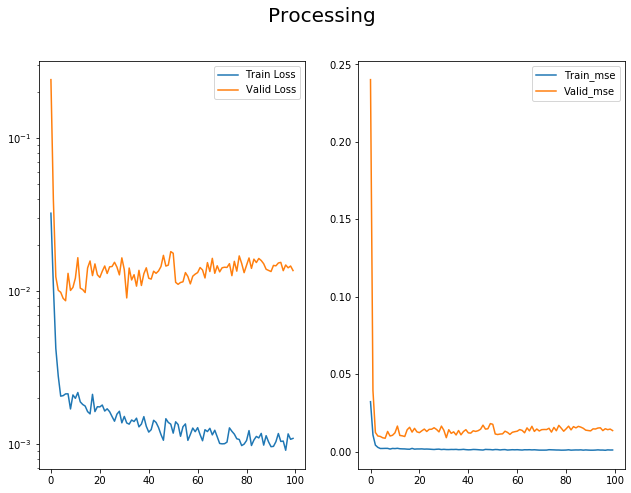

45/45 [==============================] - 3s 67ms/step - loss: 0.0011 - mse: 0.0011 - val_loss: 0.0136 - val_mse: 0.0136


In [26]:
history = model2.fit(X_train2, y_train2,
                    validation_data = (X_test2, y_test2), 
                    epochs=config["epoch"], 
                    batch_size=config["batch_size"],
                    verbose=config['verbose'],
                    callbacks=[plot])

In [27]:
# Predict train & test sets

train_pred2 = model2.predict(X_train2)
train_pred_inverse2 = scaler.inverse_transform(train_pred2)
y_train_inverse2 = scaler.inverse_transform(np.array(y_train2.reshape(-1,1)))

test_pred2 = model2.predict(X_test2)
test_pred_inverse2 = scaler.inverse_transform(test_pred2)
y_test_inverse2 = scaler.inverse_transform(np.array(y_test2.reshape(-1,1)))

In [28]:
# Root Mean Squared Error for train & test sets

rmse_train2 = math.sqrt(mean_squared_error(y_train_inverse2, train_pred_inverse2))
rmse_test2 = math.sqrt(mean_squared_error(y_test_inverse2, test_pred_inverse2))
print('RMSE for train: %0.2f' % rmse_train2)
print('RMSE for test: %0.2f' % rmse_test2)

RMSE for train: 31.59
RMSE for test: 139.44


In [29]:
# Mean Absolute Percentage Error

mape_train2 = math.sqrt(mean_absolute_percentage_error(y_train_inverse2, train_pred_inverse2))
mape_test2 = math.sqrt(mean_absolute_percentage_error(y_test_inverse2, test_pred_inverse2))
print('MAPE for train: %0.2f' % mape_train2)
print('MAPE for test: %0.2f' % mape_test2)

MAPE for train: 0.32
MAPE for test: 0.32
